In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install association_metrics

  Preparing metadata (setup.py) ... done
  Created wheel for association_metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3928 sha256=0d7c5fe9325724368291ea7450039c87b54f4297c2a545f2eec337d351be2f46
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association_metrics
Note: you may need to restart the kernel to use updated packages.


In [3]:

#импорт библиотек

import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import association_metrics as am
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import association_metrics as am
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
train_df = pd.read_csv("/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_train.csv")

In [6]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [7]:
train_df.describe()

,REF,Review,Rating
count,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,3.176494
std,551.284249,2.922499,0.478948
min,5.000000,2006.000000,1.000000
25%,593.000000,2010.000000,2.750000
50%,1077.000000,2013.000000,3.250000
75%,1514.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


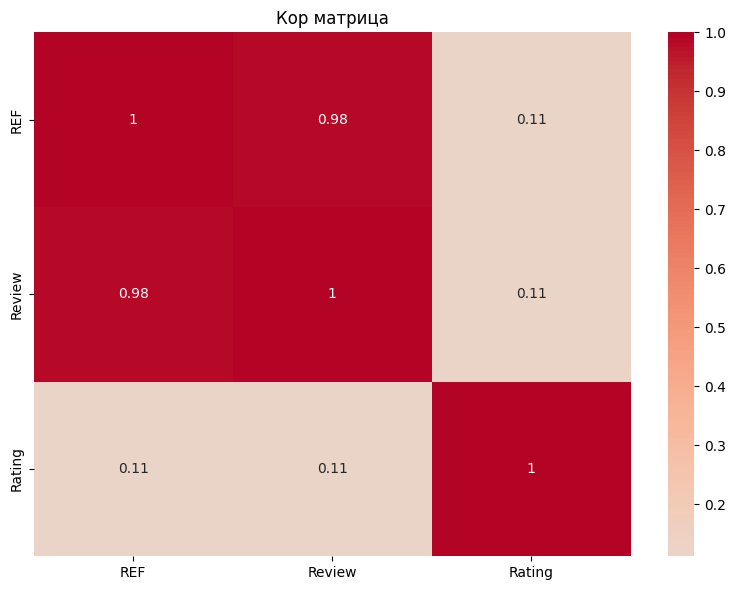

In [8]:
plt.figure(figsize=(8, 6))
correlation_matrix = train_df.select_dtypes(include=['float64', 'int64']).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Кор матрица')
plt.tight_layout()
plt.show()

In [9]:
train_df.dropna(axis=0, inplace=True)

Выделяем матрицу объект-признак и вектор с целевой переменной

In [10]:
y_train = train_df['Rating']
X_train = train_df.drop('Rating', axis=1)

In [11]:
X_train

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,Criollo,Indonesia
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80%,U.K.,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,2016,70%,Peru,,Peru
1252,Arete,Nacional,1534,2015,68%,U.S.A.,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72%,U.S.A.,,Dominican Republic


Убираем пустые значения и преобразуем проценты в числовой столбец:

In [12]:
def clean(df):
    _df = df.copy()
    _df['Cocoa Percent_numeric'] = _df['Cocoa Percent'].str.rstrip('%').astype(float)
    _df['Broad Bean Origin_cat'] = _df['Broad Bean Origin'].str.split(',', expand=True)[0].replace('\xa0', np.nan)
    _df['Bean Type_cat'] = _df['Bean Type'].str.split(r'[ ,(]', expand=True)[0].replace('\xa0', np.nan)
    _df['Specific Bean Origin_cat'] = _df['Specific Bean Origin'].str.split(',', expand=True)[0].replace('\xa0', np.nan)
    _df = _df.drop(['REF', 'Cocoa Percent', 'Bean Type', 'Broad Bean Origin', 'Specific Bean Origin'], axis=1)
    return _df

X_train_cleaned = clean(X_train)

In [13]:
discretizer = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='kmeans', random_state=42)
discretizer.fit(X_train_cleaned[['Cocoa Percent_numeric']])

X_train_cleaned['Cocoa Percent_numeric_binned'] = discretizer.transform(X_train_cleaned[['Cocoa Percent_numeric']])
X_train_cleaned.drop('Cocoa Percent_numeric', axis=1, inplace=True)

In [14]:
X_train_cleaned['Cocoa Percent_numeric_binned'].value_counts()

Cocoa Percent_numeric_binned
4.0     520
5.0     373
3.0     115
6.0      95
2.0      57
7.0      44
10.0     15
1.0      14
9.0      10
8.0       8
0.0       2
Name: count, dtype: int64

In [15]:
XC = X_train_cleaned.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Company Location,Broad Bean Origin_cat,Bean Type_cat,Specific Bean Origin_cat
Company,1.000000,0.999651,0.633931,0.816914,0.653217
Company Location,0.999651,1.000000,0.378944,0.268613,0.735872
Broad Bean Origin_cat,0.633931,0.378944,1.000000,0.506266,0.976352
Bean Type_cat,0.816914,0.268613,0.506266,1.000000,0.871187
Specific Bean Origin_cat,0.653217,0.735872,0.976352,0.871187,1.000000


In [16]:
X_train_cleaned.drop('Broad Bean Origin_cat', axis=1, inplace=True)

In [17]:
X_train_cleaned['Bean Type_cat'] = X_train_cleaned.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_train_cleaned['Bean Type_cat'] = X_train_cleaned['Bean Type_cat'].fillna('UNKNOWN')

## Обучение модели (распараллелим на все ядра и поставим обучаться)


In [18]:
X_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       1253 non-null   object 
 1   Review                        1253 non-null   int64  
 2   Company Location              1253 non-null   object 
 3   Bean Type_cat                 1253 non-null   object 
 4   Specific Bean Origin_cat      1253 non-null   object 
 5   Cocoa Percent_numeric_binned  1253 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 68.5+ KB


In [19]:
X_train_cleaned

,Company,Review,Company Location,Bean Type_cat,Specific Bean Origin_cat,Cocoa Percent_numeric_binned
0,Willie's Cacao,2009,U.K.,Trinitario,Rio Caribe,5.0
1,Beschle (Felchlin),2010,Switzerland,Criollo,Ocumare,5.0
2,Dark Forest,2015,U.S.A.,Criollo,Tanzania,4.0
3,Brasstown aka It's Chocolate,2013,U.S.A.,Trinitario,Cooproagro,5.0
4,Pralus,2006,France,Criollo,Java,5.0
...,...,...,...,...,...,...
1250,Artisan du Chocolat,2009,U.K.,Criollo,Madagascar,6.0
1251,Marana,2016,Peru,UNKNOWN,Cusco,4.0
1252,Arete,2015,U.S.A.,Forastero,Nacional,4.0
1253,Fresco,2011,U.S.A.,Trinitario,Conacado,5.0


In [20]:
cat_features = [0, 2, 3, 4]

In [21]:
cat_features = [0, 2, 3, 4]
model = CatBoostRegressor(cat_features=cat_features)
model.fit(X_train_cleaned, y_train)

Learning rate set to 0.042428
0:	learn: 0.4760524	total: 57.4ms	remaining: 57.3s
1:	learn: 0.4737916	total: 60.9ms	remaining: 30.4s
2:	learn: 0.4717400	total: 64.8ms	remaining: 21.5s
3:	learn: 0.4703577	total: 67.7ms	remaining: 16.9s
4:	learn: 0.4685378	total: 70.8ms	remaining: 14.1s
5:	learn: 0.4670697	total: 72ms	remaining: 11.9s
6:	learn: 0.4650826	total: 74.9ms	remaining: 10.6s
7:	learn: 0.4638244	total: 75.9ms	remaining: 9.41s
8:	learn: 0.4615663	total: 78.7ms	remaining: 8.66s
9:	learn: 0.4599468	total: 81ms	remaining: 8.02s
10:	learn: 0.4586754	total: 83.6ms	remaining: 7.51s
11:	learn: 0.4573518	total: 86ms	remaining: 7.08s
12:	learn: 0.4555792	total: 88.6ms	remaining: 6.73s
13:	learn: 0.4537747	total: 91ms	remaining: 6.41s
14:	learn: 0.4525589	total: 92.8ms	remaining: 6.1s
15:	learn: 0.4508193	total: 95ms	remaining: 5.84s
16:	learn: 0.4491474	total: 97.4ms	remaining: 5.63s
17:	learn: 0.4479289	total: 99.2ms	remaining: 5.41s
18:	learn: 0.4465353	total: 102ms	remaining: 5.28s
19:	

In [22]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [23]:
import optuna
from sklearn.metrics import mean_squared_error
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'depth': trial.suggest_int('depth', 2, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'cat_features': cat_features,
        'random_state': 42
    }
    model = CatBoostRegressor(**params,thread_count=-1)
    model.fit(X_train_cleaned, y_train, use_best_model=True)

    preds = model.predict(X_train_cleaned)

    rmse = mean_squared_error(y_train, preds, )
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10,n_jobs=-1,timeout=600)  

print('Лучшее значение RMSE: {}'.format(study.best_value))
print('Лучшие параметры: ')
for key, value in study.best_params.items():
    print('    {}: {}'.format(key, value))

best_params = study.best_params
best_params['cat_features'] = cat_features
best_params['task_type'] = 'CPU'
best_params['random_state'] = 42
best_params['verbose'] = True

model = CatBoostRegressor(**best_params,thread_count=28)
model.fit(X_train_cleaned, y_train)

[I 2025-03-14 21:30:50,889] A new study created in memory with name: no-name-ef62dbcb-3553-4ac7-8c6b-068639d67425
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.4779214	total: 7.32ms	remaining: 1.05s
0:	learn: 0.4775427	total: 2.98ms	remaining: 1.19s
1:	learn: 0.4776894	total: 12ms	remaining: 856ms
1:	learn: 0.4769219	total: 7ms	remaining: 1.4s
0:	learn: 0.4781148	total: 3.06ms	remaining: 2.42s
2:	learn: 0.4774310	total: 14.5ms	remaining: 685ms
2:	learn: 0.4763270	total: 11.5ms	remaining: 1.52s
3:	learn: 0.4771617	total: 17.7ms	remaining: 625ms
1:	learn: 0.4780399	total: 7.7ms	remaining: 3.04s
2:	learn: 0.4779721	total: 9.68ms	remaining: 2.54s
4:	learn: 0.4769573	total: 21.1ms	remaining: 591ms
3:	learn: 0.4779198	total: 11.7ms	remaining: 2.3s
5:	learn: 0.4767345	total: 23ms	remaining: 533ms
4:	learn: 0.4778426	total: 13.5ms	remaining: 2.12s
3:	learn: 0.4758991	total: 20.1ms	remaining: 2s
5:	learn: 0.4777681	total: 15.1ms	remaining: 1.98s
4:	learn: 0.4753448	total: 22.4ms	remaining: 1.77s
6:	learn: 0.4764447	total: 28.5ms	remaining: 561ms
5:	learn: 0.4747951	total: 24.8ms	remaining: 1.63s
7:	learn: 0.4761870	total: 30.4ms	remaining:

[I 2025-03-14 21:30:51,536] Trial 0 finished with value: 0.19216118789954514 and parameters: {'iterations': 145, 'depth': 5, 'learning_rate': 0.004435376938645493}. Best is trial 0 with value: 0.19216118789954514.
You should provide test set for use best model. use_best_model parameter has been switched to false value.


192:	learn: 0.4314036	total: 571ms	remaining: 615ms
111:	learn: 0.4698700	total: 574ms	remaining: 6.34s
209:	learn: 0.4659626	total: 568ms	remaining: 1.57s
210:	learn: 0.4659233	total: 569ms	remaining: 1.56s
193:	learn: 0.4313163	total: 572ms	remaining: 611ms
211:	learn: 0.4658788	total: 572ms	remaining: 1.56s
112:	learn: 0.4697877	total: 578ms	remaining: 6.32s
194:	learn: 0.4311897	total: 576ms	remaining: 608ms
212:	learn: 0.4658332	total: 573ms	remaining: 1.55s
213:	learn: 0.4657760	total: 574ms	remaining: 1.55s
195:	learn: 0.4310198	total: 579ms	remaining: 605ms
214:	learn: 0.4657215	total: 575ms	remaining: 1.54s
113:	learn: 0.4697062	total: 584ms	remaining: 6.32s
196:	learn: 0.4309955	total: 581ms	remaining: 602ms
0:	learn: 0.4745556	total: 7.82ms	remaining: 5.56s
114:	learn: 0.4696234	total: 587ms	remaining: 6.29s
197:	learn: 0.4308985	total: 584ms	remaining: 598ms
198:	learn: 0.4308198	total: 585ms	remaining: 593ms
1:	learn: 0.4719282	total: 11.3ms	remaining: 4.01s
115:	learn: 0.

[I 2025-03-14 21:30:52,201] Trial 1 finished with value: 0.14630926123582544 and parameters: {'iterations': 401, 'depth': 3, 'learning_rate': 0.011542880958352769}. Best is trial 1 with value: 0.14630926123582544.


227:	learn: 0.4622694	total: 1.15s	remaining: 5.63s
413:	learn: 0.4571798	total: 1.09s	remaining: 991ms
414:	learn: 0.4571478	total: 1.09s	remaining: 987ms
111:	learn: 0.3896599	total: 571ms	remaining: 3.06s
228:	learn: 0.4622069	total: 1.15s	remaining: 5.63s
229:	learn: 0.4621401	total: 1.15s	remaining: 5.61s
415:	learn: 0.4571134	total: 1.09s	remaining: 987ms
230:	learn: 0.4620680	total: 1.16s	remaining: 5.6s
416:	learn: 0.4570694	total: 1.1s	remaining: 984ms
112:	learn: 0.3895080	total: 579ms	remaining: 3.07s
417:	learn: 0.4570183	total: 1.1s	remaining: 981ms
113:	learn: 0.3892375	total: 583ms	remaining: 3.06s
231:	learn: 0.4620151	total: 1.16s	remaining: 5.6s
418:	learn: 0.4569744	total: 1.1s	remaining: 979ms
233:	learn: 0.4618782	total: 1.17s	remaining: 5.56s
420:	learn: 0.4568844	total: 1.1s	remaining: 972ms
115:	learn: 0.3886648	total: 591ms	remaining: 3.03s
116:	learn: 0.3882196	total: 593ms	remaining: 3.01s
234:	learn: 0.4618259	total: 1.17s	remaining: 5.55s
421:	learn: 0.4568

You should provide test set for use best model. use_best_model parameter has been switched to false value.


149:	learn: 0.3770770	total: 747ms	remaining: 2.8s
44:	learn: 0.4749708	total: 123ms	remaining: 216ms
45:	learn: 0.4749031	total: 124ms	remaining: 210ms
266:	learn: 0.4599761	total: 1.33s	remaining: 5.38s
479:	learn: 0.4547718	total: 1.25s	remaining: 808ms
150:	learn: 0.3770445	total: 753ms	remaining: 2.8s
46:	learn: 0.4748286	total: 129ms	remaining: 211ms
480:	learn: 0.4547284	total: 1.25s	remaining: 806ms
267:	learn: 0.4599166	total: 1.33s	remaining: 5.38s
268:	learn: 0.4598732	total: 1.33s	remaining: 5.36s
47:	learn: 0.4747734	total: 132ms	remaining: 210ms
151:	learn: 0.3768783	total: 759ms	remaining: 2.8s
481:	learn: 0.4546936	total: 1.25s	remaining: 803ms
48:	learn: 0.4747236	total: 136ms	remaining: 208ms
482:	learn: 0.4546409	total: 1.26s	remaining: 801ms
269:	learn: 0.4598269	total: 1.34s	remaining: 5.36s
152:	learn: 0.3766865	total: 765ms	remaining: 2.79s
49:	learn: 0.4746590	total: 140ms	remaining: 207ms
483:	learn: 0.4546008	total: 1.26s	remaining: 799ms
484:	learn: 0.4545618

[I 2025-03-14 21:30:52,628] Trial 5 finished with value: 0.21682702144029056 and parameters: {'iterations': 124, 'depth': 4, 'learning_rate': 0.0013251005489611823}. Best is trial 1 with value: 0.14630926123582544.


549:	learn: 0.4524091	total: 1.43s	remaining: 626ms
183:	learn: 0.3696084	total: 943ms	remaining: 2.71s
120:	learn: 0.4703404	total: 312ms	remaining: 7.73ms
121:	learn: 0.4702742	total: 313ms	remaining: 5.13ms
306:	learn: 0.4577062	total: 1.52s	remaining: 5.17s
122:	learn: 0.4702154	total: 315ms	remaining: 2.56ms
184:	learn: 0.3695773	total: 948ms	remaining: 2.7s
550:	learn: 0.4523591	total: 1.44s	remaining: 625ms
551:	learn: 0.4523218	total: 1.44s	remaining: 622ms
123:	learn: 0.4701604	total: 319ms	remaining: 0us
552:	learn: 0.4523068	total: 1.44s	remaining: 619ms
185:	learn: 0.3694529	total: 954ms	remaining: 2.7s
307:	learn: 0.4576549	total: 1.53s	remaining: 5.18s
553:	learn: 0.4522768	total: 1.44s	remaining: 617ms
554:	learn: 0.4522476	total: 1.44s	remaining: 614ms
308:	learn: 0.4576050	total: 1.54s	remaining: 5.16s
186:	learn: 0.3692016	total: 959ms	remaining: 2.69s
555:	learn: 0.4522239	total: 1.45s	remaining: 611ms
309:	learn: 0.4575597	total: 1.54s	remaining: 5.15s
187:	learn: 0

You should provide test set for use best model. use_best_model parameter has been switched to false value.


23:	learn: 0.4753965	total: 123ms	remaining: 6.6s
348:	learn: 0.4556325	total: 1.7s	remaining: 4.87s
225:	learn: 0.3612547	total: 1.12s	remaining: 2.42s
24:	learn: 0.4752864	total: 128ms	remaining: 6.58s
349:	learn: 0.4555733	total: 1.71s	remaining: 4.86s
613:	learn: 0.4504920	total: 1.61s	remaining: 465ms
226:	learn: 0.3610198	total: 1.13s	remaining: 2.41s
614:	learn: 0.4504602	total: 1.62s	remaining: 463ms
350:	learn: 0.4555074	total: 1.71s	remaining: 4.86s
25:	learn: 0.4751846	total: 135ms	remaining: 6.69s
615:	learn: 0.4504308	total: 1.62s	remaining: 460ms
227:	learn: 0.3607867	total: 1.13s	remaining: 2.41s
26:	learn: 0.4750794	total: 138ms	remaining: 6.57s
616:	learn: 0.4504000	total: 1.62s	remaining: 457ms
617:	learn: 0.4503732	total: 1.62s	remaining: 454ms
27:	learn: 0.4749629	total: 145ms	remaining: 6.64s
228:	learn: 0.3604706	total: 1.14s	remaining: 2.41s
618:	learn: 0.4503458	total: 1.63s	remaining: 452ms
28:	learn: 0.4748722	total: 149ms	remaining: 6.56s
619:	learn: 0.450318

[I 2025-03-14 21:30:53,417] Trial 2 finished with value: 0.18361216783014359 and parameters: {'iterations': 791, 'depth': 3, 'learning_rate': 0.0013711477862016167}. Best is trial 1 with value: 0.14630926123582544.


343:	learn: 0.3391219	total: 1.69s	remaining: 1.81s
136:	learn: 0.4642541	total: 687ms	remaining: 5.88s
461:	learn: 0.4502629	total: 2.27s	remaining: 4.36s
462:	learn: 0.4502295	total: 2.28s	remaining: 4.35s
345:	learn: 0.3388366	total: 1.7s	remaining: 1.8s
138:	learn: 0.4640977	total: 691ms	remaining: 5.82s
350:	learn: 0.3381680	total: 1.71s	remaining: 1.76s
467:	learn: 0.4499938	total: 2.29s	remaining: 4.31s
140:	learn: 0.4638851	total: 705ms	remaining: 5.84s
351:	learn: 0.3381049	total: 1.72s	remaining: 1.76s
468:	learn: 0.4499637	total: 2.3s	remaining: 4.3s
352:	learn: 0.3379308	total: 1.72s	remaining: 1.75s
353:	learn: 0.3376147	total: 1.72s	remaining: 1.74s
141:	learn: 0.4637844	total: 711ms	remaining: 5.85s
469:	learn: 0.4499059	total: 2.3s	remaining: 4.3s
142:	learn: 0.4637264	total: 714ms	remaining: 5.83s
354:	learn: 0.3374062	total: 1.72s	remaining: 1.73s
355:	learn: 0.3373045	total: 1.72s	remaining: 1.72s
470:	learn: 0.4498665	total: 2.31s	remaining: 4.3s
356:	learn: 0.33694

You should provide test set for use best model. use_best_model parameter has been switched to false value.


496:	learn: 0.4488130	total: 2.46s	remaining: 4.21s
26:	learn: 0.4774996	total: 146ms	remaining: 1.57s
174:	learn: 0.4609033	total: 873ms	remaining: 5.66s
391:	learn: 0.3312124	total: 1.88s	remaining: 1.53s
497:	learn: 0.4487657	total: 2.47s	remaining: 4.21s
175:	learn: 0.4608134	total: 875ms	remaining: 5.64s
27:	learn: 0.4774745	total: 155ms	remaining: 1.6s
176:	learn: 0.4607133	total: 877ms	remaining: 5.62s
392:	learn: 0.3311916	total: 1.89s	remaining: 1.53s
177:	learn: 0.4606456	total: 880ms	remaining: 5.6s
498:	learn: 0.4487187	total: 2.47s	remaining: 4.21s
28:	learn: 0.4774470	total: 161ms	remaining: 1.59s
499:	learn: 0.4486615	total: 2.48s	remaining: 4.2s
178:	learn: 0.4605471	total: 885ms	remaining: 5.59s
393:	learn: 0.3308495	total: 1.89s	remaining: 1.53s
394:	learn: 0.3306578	total: 1.9s	remaining: 1.52s
500:	learn: 0.4486250	total: 2.48s	remaining: 4.2s
29:	learn: 0.4774225	total: 167ms	remaining: 1.59s
179:	learn: 0.4604804	total: 892ms	remaining: 5.6s
501:	learn: 0.4485848	

[I 2025-03-14 21:30:55,146] Trial 7 finished with value: 0.21807720454180832 and parameters: {'iterations': 316, 'depth': 5, 'learning_rate': 0.00045734031929280485}. Best is trial 1 with value: 0.14630926123582544.


437:	learn: 0.4432652	total: 2.17s	remaining: 4.32s
659:	learn: 0.2945566	total: 3.19s	remaining: 251ms
303:	learn: 0.4707821	total: 1.43s	remaining: 56.5ms
757:	learn: 0.4392550	total: 3.79s	remaining: 2.95s
438:	learn: 0.4432123	total: 2.18s	remaining: 4.32s
304:	learn: 0.4707596	total: 1.43s	remaining: 51.7ms
660:	learn: 0.2944471	total: 3.19s	remaining: 246ms
439:	learn: 0.4431745	total: 2.18s	remaining: 4.31s
305:	learn: 0.4707415	total: 1.44s	remaining: 47ms
758:	learn: 0.4392226	total: 3.8s	remaining: 2.95s
440:	learn: 0.4431247	total: 2.18s	remaining: 4.3s
661:	learn: 0.2943623	total: 3.2s	remaining: 242ms
306:	learn: 0.4707204	total: 1.44s	remaining: 42.3ms
759:	learn: 0.4391902	total: 3.81s	remaining: 2.94s
441:	learn: 0.4430720	total: 2.19s	remaining: 4.3s
307:	learn: 0.4706940	total: 1.45s	remaining: 37.5ms
662:	learn: 0.2942033	total: 3.21s	remaining: 237ms
760:	learn: 0.4391580	total: 3.81s	remaining: 2.94s
308:	learn: 0.4706687	total: 1.45s	remaining: 32.8ms
761:	learn: 

You should provide test set for use best model. use_best_model parameter has been switched to false value.
[I 2025-03-14 21:30:55,363] Trial 4 finished with value: 0.1124635065321003 and parameters: {'iterations': 712, 'depth': 5, 'learning_rate': 0.06560229376635697}. Best is trial 4 with value: 0.1124635065321003.


21:	learn: 0.4560065	total: 62.7ms	remaining: 5.33s
476:	learn: 0.4413737	total: 2.36s	remaining: 4.12s
22:	learn: 0.4552065	total: 63.6ms	remaining: 5.17s
800:	learn: 0.4379751	total: 3.98s	remaining: 2.72s
23:	learn: 0.4544995	total: 64.9ms	remaining: 5.04s
699:	learn: 0.2906043	total: 3.38s	remaining: 57.9ms
24:	learn: 0.4536855	total: 67.4ms	remaining: 5.03s
25:	learn: 0.4531001	total: 68.9ms	remaining: 4.94s
477:	learn: 0.4413398	total: 2.37s	remaining: 4.12s
700:	learn: 0.2905670	total: 3.38s	remaining: 53.1ms
26:	learn: 0.4524848	total: 69.9ms	remaining: 4.82s
801:	learn: 0.4379476	total: 3.98s	remaining: 2.71s
701:	learn: 0.2904829	total: 3.38s	remaining: 48.2ms
802:	learn: 0.4379194	total: 3.98s	remaining: 2.7s
702:	learn: 0.2904398	total: 3.39s	remaining: 43.4ms
478:	learn: 0.4412658	total: 2.37s	remaining: 4.12s
27:	learn: 0.4519348	total: 76.7ms	remaining: 5.1s
803:	learn: 0.4378848	total: 3.99s	remaining: 2.7s
28:	learn: 0.4511303	total: 78.4ms	remaining: 5.03s
479:	learn:

You should provide test set for use best model. use_best_model parameter has been switched to false value.


511:	learn: 0.4396611	total: 2.55s	remaining: 3.97s
16:	learn: 0.4775188	total: 50.4ms	remaining: 5.86s
17:	learn: 0.4774795	total: 51.6ms	remaining: 5.67s
512:	learn: 0.4396117	total: 2.55s	remaining: 3.96s
124:	learn: 0.4273260	total: 239ms	remaining: 3.37s
833:	learn: 0.4369723	total: 4.16s	remaining: 2.56s
125:	learn: 0.4271442	total: 241ms	remaining: 3.38s
18:	learn: 0.4774450	total: 53.4ms	remaining: 5.55s
19:	learn: 0.4774009	total: 54.9ms	remaining: 5.41s
513:	learn: 0.4395637	total: 2.56s	remaining: 3.96s
20:	learn: 0.4773627	total: 56.6ms	remaining: 5.32s
126:	learn: 0.4269975	total: 245ms	remaining: 3.41s
834:	learn: 0.4369539	total: 4.17s	remaining: 2.56s
127:	learn: 0.4269229	total: 248ms	remaining: 3.41s
21:	learn: 0.4773265	total: 58.8ms	remaining: 5.27s
128:	learn: 0.4266655	total: 249ms	remaining: 3.4s
22:	learn: 0.4772829	total: 60.6ms	remaining: 5.19s
514:	learn: 0.4394974	total: 2.56s	remaining: 3.96s
835:	learn: 0.4369221	total: 4.17s	remaining: 2.56s
129:	learn: 0

[I 2025-03-14 21:30:58,403] Trial 3 finished with value: 0.15995482593242213 and parameters: {'iterations': 1348, 'depth': 5, 'learning_rate': 0.0014371724358323494}. Best is trial 4 with value: 0.1124635065321003.


1004:	learn: 0.4227183	total: 5.19s	remaining: 1.57s
946:	learn: 0.4526791	total: 2.53s	remaining: 2.79s
1345:	learn: 0.4248868	total: 6.77s	remaining: 10.1ms
1411:	learn: 0.3873756	total: 2.67s	remaining: 906ms
1412:	learn: 0.3873708	total: 2.68s	remaining: 903ms
947:	learn: 0.4526603	total: 2.53s	remaining: 2.79s
1413:	learn: 0.3873674	total: 2.68s	remaining: 901ms
948:	learn: 0.4526436	total: 2.54s	remaining: 2.79s
1414:	learn: 0.3873514	total: 2.68s	remaining: 900ms
949:	learn: 0.4526246	total: 2.54s	remaining: 2.79s
1415:	learn: 0.3873259	total: 2.68s	remaining: 898ms
1346:	learn: 0.4248678	total: 6.78s	remaining: 5.03ms
1005:	learn: 0.4226960	total: 5.2s	remaining: 1.57s
1416:	learn: 0.3873180	total: 2.68s	remaining: 895ms
950:	learn: 0.4526067	total: 2.54s	remaining: 2.78s
1347:	learn: 0.4248532	total: 6.79s	remaining: 0us
1417:	learn: 0.3873024	total: 2.69s	remaining: 894ms
1006:	learn: 0.4226729	total: 5.2s	remaining: 1.56s
951:	learn: 0.4525881	total: 2.54s	remaining: 2.78s
1

[I 2025-03-14 21:30:58,986] Trial 8 finished with value: 0.12713580869801278 and parameters: {'iterations': 1890, 'depth': 2, 'learning_rate': 0.03495613140125852}. Best is trial 4 with value: 0.1124635065321003.


1860:	learn: 0.3817876	total: 3.15s	remaining: 49.2ms
1207:	learn: 0.4483566	total: 3.04s	remaining: 1.97s
1206:	learn: 0.4180908	total: 5.74s	remaining: 490ms
1208:	learn: 0.4483368	total: 3.04s	remaining: 1.97s
1207:	learn: 0.4180595	total: 5.74s	remaining: 485ms
1861:	learn: 0.3817775	total: 3.15s	remaining: 47.5ms
1862:	learn: 0.3817700	total: 3.16s	remaining: 45.7ms
1209:	learn: 0.4483189	total: 3.04s	remaining: 1.97s
1863:	learn: 0.3817424	total: 3.16s	remaining: 44ms
1864:	learn: 0.3817113	total: 3.16s	remaining: 42.3ms
1865:	learn: 0.3817052	total: 3.16s	remaining: 40.6ms
1210:	learn: 0.4483058	total: 3.04s	remaining: 1.97s
1211:	learn: 0.4482908	total: 3.04s	remaining: 1.96s
1208:	learn: 0.4180108	total: 5.75s	remaining: 480ms
1212:	learn: 0.4482775	total: 3.05s	remaining: 1.96s
1866:	learn: 0.3816569	total: 3.16s	remaining: 39ms
1213:	learn: 0.4482654	total: 3.05s	remaining: 1.96s
1867:	learn: 0.3816396	total: 3.16s	remaining: 37.3ms
1868:	learn: 0.3816367	total: 3.16s	remain

[I 2025-03-14 21:30:59,254] Trial 6 finished with value: 0.14962387278874625 and parameters: {'iterations': 1310, 'depth': 5, 'learning_rate': 0.002100713205874501}. Best is trial 4 with value: 0.1124635065321003.


1330:	learn: 0.4465841	total: 3.21s	remaining: 1.6s
1284:	learn: 0.4163994	total: 5.92s	remaining: 115ms
1331:	learn: 0.4465674	total: 3.22s	remaining: 1.6s
1332:	learn: 0.4465582	total: 3.22s	remaining: 1.59s
1285:	learn: 0.4163826	total: 5.93s	remaining: 111ms
1286:	learn: 0.4163347	total: 5.93s	remaining: 106ms
1333:	learn: 0.4465508	total: 3.22s	remaining: 1.59s
1287:	learn: 0.4163239	total: 5.93s	remaining: 101ms
1334:	learn: 0.4465437	total: 3.22s	remaining: 1.59s
1335:	learn: 0.4465280	total: 3.23s	remaining: 1.59s
1288:	learn: 0.4162970	total: 5.93s	remaining: 96.7ms
1336:	learn: 0.4465118	total: 3.23s	remaining: 1.58s
1289:	learn: 0.4162910	total: 5.93s	remaining: 92ms
1337:	learn: 0.4465030	total: 3.23s	remaining: 1.58s
1338:	learn: 0.4464927	total: 3.23s	remaining: 1.58s
1339:	learn: 0.4464859	total: 3.23s	remaining: 1.57s
1290:	learn: 0.4162682	total: 5.94s	remaining: 87.4ms
1340:	learn: 0.4464738	total: 3.23s	remaining: 1.57s
1341:	learn: 0.4464595	total: 3.23s	remaining: 

[I 2025-03-14 21:30:59,860] Trial 9 finished with value: 0.17306707310798938 and parameters: {'iterations': 1993, 'depth': 3, 'learning_rate': 0.0007639755121153474}. Best is trial 4 with value: 0.1124635065321003.


1891:	learn: 0.4398128	total: 3.75s	remaining: 200ms
1892:	learn: 0.4398028	total: 3.75s	remaining: 198ms
1893:	learn: 0.4397927	total: 3.75s	remaining: 196ms
1894:	learn: 0.4397831	total: 3.75s	remaining: 194ms
1895:	learn: 0.4397730	total: 3.76s	remaining: 192ms
1896:	learn: 0.4397591	total: 3.76s	remaining: 190ms
1897:	learn: 0.4397502	total: 3.76s	remaining: 188ms
1898:	learn: 0.4397334	total: 3.76s	remaining: 186ms
1899:	learn: 0.4397253	total: 3.76s	remaining: 184ms
1900:	learn: 0.4397127	total: 3.76s	remaining: 182ms
1901:	learn: 0.4397041	total: 3.76s	remaining: 180ms
1902:	learn: 0.4396954	total: 3.76s	remaining: 178ms
1903:	learn: 0.4396842	total: 3.76s	remaining: 176ms
1904:	learn: 0.4396754	total: 3.76s	remaining: 174ms
1905:	learn: 0.4396601	total: 3.77s	remaining: 172ms
1906:	learn: 0.4396527	total: 3.77s	remaining: 170ms
1907:	learn: 0.4396443	total: 3.77s	remaining: 168ms
1908:	learn: 0.4396339	total: 3.77s	remaining: 166ms
1909:	learn: 0.4396252	total: 3.77s	remaining:

In [24]:
model.score(X_train_cleaned, y_train)

0.5081795172370828

## тест


In [25]:
test_df = pd.read_csv("/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_test_new.csv")

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


In [27]:
X_test_cleaned = clean(test_df)
X_test_cleaned['Cocoa Percent_numeric_binned'] = discretizer.transform(X_test_cleaned[['Cocoa Percent_numeric']])
X_test_cleaned.drop(['Broad Bean Origin_cat', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [28]:
X_test_cleaned['Bean Type_cat'] = X_test_cleaned.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_test_cleaned['Bean Type_cat'] = X_test_cleaned['Bean Type_cat'].fillna('UNKNOWN')

In [29]:
X_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       540 non-null    object 
 1   Review                        540 non-null    int64  
 2   Company Location              540 non-null    object 
 3   Bean Type_cat                 540 non-null    object 
 4   Specific Bean Origin_cat      540 non-null    object 
 5   Cocoa Percent_numeric_binned  540 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 25.4+ KB


Делаем предсказание

In [30]:
pred = model.predict(X_test_cleaned)

Сохраняем предсказание в файл в нужном формате

In [31]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred

test_df[['id','Rating']].to_csv("submission.csv", index=False)